# Fit with smooth potential + smooth or pixelated source

__last update__: 16/05/22

In [1]:
%config InlineBackend.figure_format = 'retina'

import os
import time
import numpy as np
import pickle as pkl
from pprint import pprint
import matplotlib.pyplot as plt
from copy import deepcopy
import powerbox as pbox
import corner
from astropy.io import fits
from matplotlib.colors import LogNorm, TwoSlopeNorm, SymLogNorm
%matplotlib inline
plt.rc('image', interpolation='none')

import jax.numpy as jnp

from herculens.Instrument.psf import PSF
from herculens.LightModel.light_model import LightModel
from herculens.LensModel.lens_model import LensModel
from herculens.LensImage.lens_image import LensImage
from herculens.Parameters.parameters import Parameters
from herculens.Parameters.covariance import FisherCovariance
from herculens.Inference.loss import Loss
from herculens.Inference.optimization import Optimizer
from herculens.Inference.sampling import Sampler
from herculens.Inference.sensitivity_mapping import MassSensitivityMapping
from herculens.Analysis.plot import Plotter
from herculens.Util import param_util, model_util, molet_util
from herculens.Util.plot_util import nice_colorbar

## Global settings

In [2]:
# Save results on disk?
SAVE_MODELS_FITS = False
SAVE_MODELS_SENSIMAP = False
SAVE_MCMC = True
stop_after_smooth_fit = True

# Type of the potential perturbations that we seek to recover
perturbation_type = 'GRF' # supported choices: 'dark_halo', 'GRF', 'discyness'

# Multi-start optimization
num_fits = 10
initial_perturb_level, perturb_seed = 0.0, 8

# Source plane resolution
source_scale_factor = 1/3.

# Choice of seeing conditions
psf_type = 'gaussian'  # 'gaussian', 'molet'

# Plotting engine for modeling results
plotter = Plotter(base_fontsize=18, flux_vmin=5e-3, flux_vmax=1e0, res_vmax=6)

## Load the mock data

### Coordinate grid, noise and imaging data

In [3]:
molet_dir = '/Users/aymericg/Documents/EPFL/PhD_LASTRO/Code/Lens_modelling/wavelet-lensing-papers/paper_II/molet'
molet_simu_name = f'molet_sim_{perturbation_type}'
if psf_type == 'gaussian':
    molet_instru_name = 'gaussian03'
else:
    raise NotImplementedError("MOLET sims with non-gaussian PSFs have not been generated yet.")
    
pixel_grid, noise, psf_molet, data, psi_grid_input, noise_real, _, _ \
    = molet_util.read_molet_simulation(molet_dir, molet_simu_name,
                                       use_true_noise_map=True, 
                                       subtract_offset=True,
                                       cut_psf=20)

npix, npix_y = pixel_grid.num_pixel_axes
pix_scl = pixel_grid.pixel_width  # arcsec / pixel
xgrid, ygrid = pixel_grid.pixel_coordinates

# Native image plane coordinates
x_grid, y_grid = pixel_grid.pixel_coordinates
x_coords = x_grid[0, :]
y_coords = y_grid[:, 0]
extent = pixel_grid.extent

print(f"image size : ({npix}, {npix}) pixels")
print(f"pixel size : {pix_scl} arcsec")
print(f"x range    : {extent[0], extent[1]} arcsec")
print(f"y range    : {extent[2], extent[3]} arcsec")
print(f"exposure time : {noise.exposure_map} s")
print(f"background noise level : {noise.background_rms:.3f}")

image size : (100, 100) pixels
pixel size : 0.07999999999999999 arcsec
x range    : (-3.96, 3.96) arcsec
y range    : (-3.96, 3.96) arcsec
exposure time : None s
background noise level : 0.005


/Users/aymericg/Documents/EPFL/PhD_LASTRO/Code/Lens_modelling/autodiff/jax_herculens/herculens/Util/molet_util.py:22: UserWarning: Using MOLET instrument 'gaussian03'.
  warnings.warn(f"Using MOLET instrument '{instrument_name}'.")
/Users/aymericg/Documents/EPFL/PhD_LASTRO/Code/Lens_modelling/autodiff/jax_herculens/herculens/Util/molet_util.py:129: UserWarning: Could not prepare the 'PIXEL' PSF instance as the PSF in the instrument module is supersampled (supersampling factor?).
  warnings.warn("Could not prepare the 'PIXEL' PSF instance as the PSF in the instrument module is supersampled (supersampling factor?).")


### Point spread function

PSF kernel shape: (19, 19)


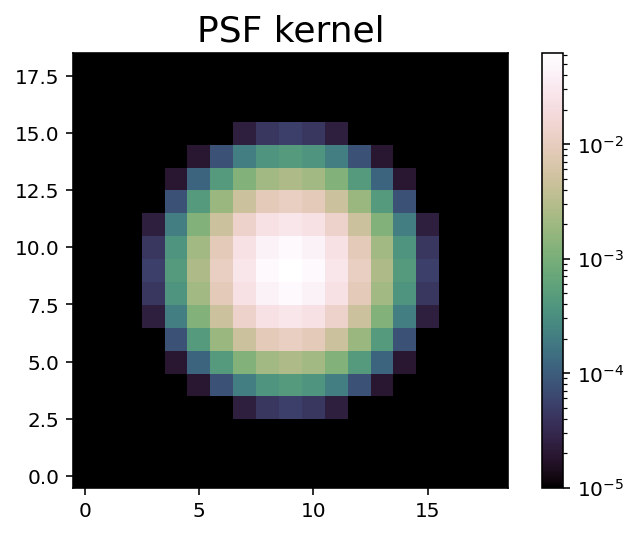

In [4]:
# PSF
if psf_type == 'gaussian':
    # Gaussian PSF
    psf = PSF(psf_type='GAUSSIAN', fwhm=0.3, truncation=5, pixel_size=pix_scl)
elif psf_type == 'molet':
    # pixelated PSF used by MOLET
    psf = psf_molet
    
print("PSF kernel shape:", psf.kernel_point_source.shape)

plt.figure()
plt.title("PSF kernel", fontsize=18)
plt.imshow(psf.kernel_point_source, origin='lower', cmap=plotter.cmap_flux, norm=LogNorm(1e-5))
plt.colorbar()
plt.show()

### Mass and light models

In [5]:
# Input lens mass model 
kwargs_macro_lens_input = {'theta_E': 1.6, 'e1': 0.15, 'e2': -0.04, 'center_x': 0.0, 'center_y': 0.0}
kwargs_ext_shear_input = {'gamma1': -0.01, 'gamma2': 0.03, 'ra_0': 0., 'dec_0': 0.}
kwargs_lens_input = [kwargs_macro_lens_input, kwargs_ext_shear_input]
phi_ext, gamma_ext = param_util.shear_cartesian2polar(kwargs_ext_shear_input['gamma1'], kwargs_ext_shear_input['gamma2'])
print(f"Input shear strength: {gamma_ext:.3f} & direction: {phi_ext*180/np.pi:.3f}")
phi, q = param_util.ellipticity2phi_q(kwargs_macro_lens_input['e1'], kwargs_macro_lens_input['e2'])
print(f"Input macro axis ratio: {q:.3f} & direction: {phi*180/np.pi:.3f}")

# Fitted lens mass model
lens_mass_model_fit = LensModel(['SIE', 'SHEAR'])

# Input source model 
source_model_input = LightModel(['SERSIC_ELLIPSE'])
kwargs_source_input = [
    {'amp': 10.0, 'R_sersic': 0.8, 'n_sersic': 2, 'e1': -0.09, 'e2': 0.03,
     'center_x': 0.4, 'center_y': 0.15}
]

# Fitted source model
cx_src = kwargs_source_input[0]['center_x']
cy_src = kwargs_source_input[0]['center_y']
kwargs_pixelated_source = {
    'pixel_scale_factor': source_scale_factor,
    'conserve_extent': False,
    'grid_center': (cx_src, cy_src),
    'grid_shape': (4.5, 4.5),
}
source_model_fit = LightModel(['PIXELATED'], kwargs_pixelated=kwargs_pixelated_source)

# Input lens light
lens_light_model_input = LightModel(['SERSIC_ELLIPSE'])
#kwargs_lens_light_input = [
#    {'amp': 12.620034,  # value from lens light fitting notebook
#     'R_sersic': 2., 'n_sersic': 2., 
#     'e1': kwargs_macro_lens_input['e1'], 'e2': kwargs_macro_lens_input['e2'], 
#     'center_x': kwargs_macro_lens_input['center_x'], 'center_y': kwargs_macro_lens_input['center_y']}
#]
kwargs_lens_light_input = [{'R_sersic': 1.9949292,
                        'amp': 12.620034,
                        'center_x': -0.00385393,
                        'center_y': -0.00458917,
                        'e1': 0.14911005,
                        'e2': -0.04016396,
                        'n_sersic': 1.9948864}]

Input shear strength: 0.032 & direction: 54.217
Input macro axis ratio: 0.731 & direction: -7.466


### Image model classes

In [6]:
kwargs_numerics = {'supersampling_factor': 1, 'convolution_type': 'grid'}

# model with analytical source
lens_image_ana = LensImage(pixel_grid, psf, noise_class=noise,
                                lens_model_class=lens_mass_model_fit,
                                source_model_class=source_model_input,
                                lens_light_model_class=lens_light_model_input,
                                kwargs_numerics=kwargs_numerics)
# fitted model with pixelated source
lens_image_fit = LensImage(pixel_grid, psf, noise_class=noise,
                                lens_model_class=lens_mass_model_fit,
                                source_model_class=source_model_fit,
                                lens_light_model_class=lens_light_model_input,
                                kwargs_numerics=kwargs_numerics)

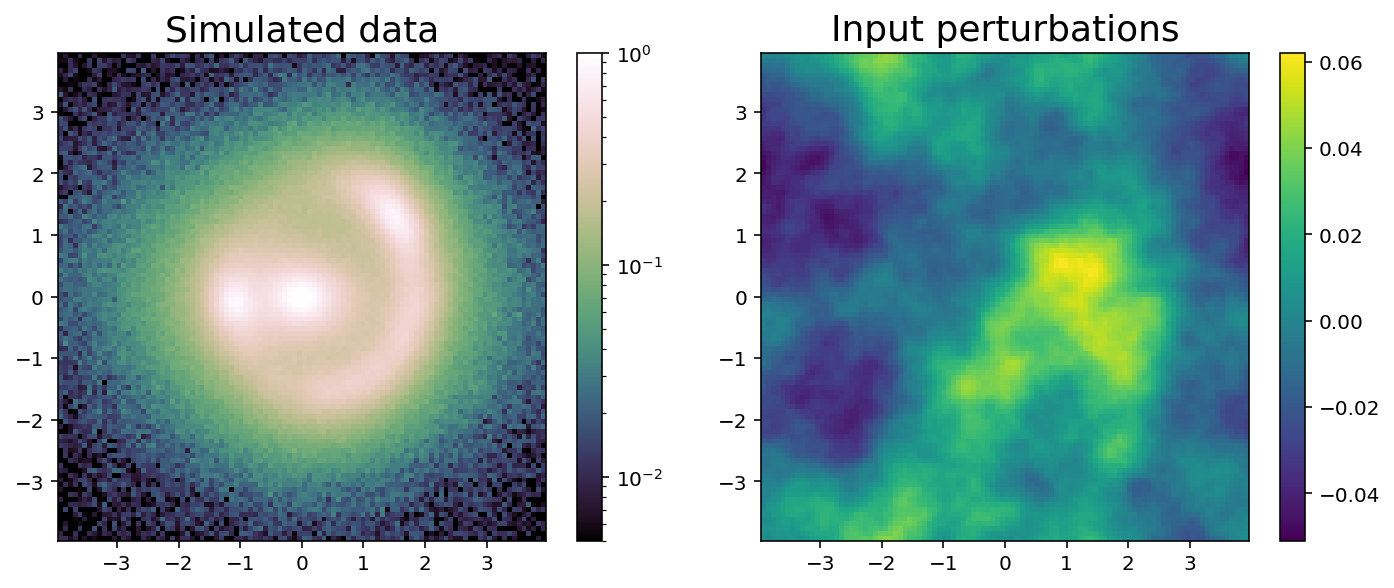

In [7]:
# get the true source surface brightness
source_input = lens_image_ana.source_surface_brightness(kwargs_source_input,
                                                        de_lensed=True, unconvolved=True)
source_input_lensed = lens_image_ana.source_surface_brightness(kwargs_source_input, 
                                                               kwargs_lens=kwargs_lens_input,
                                                               de_lensed=False, unconvolved=False)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax = axes[0]
ax.set_title("Simulated data", fontsize=18)
im = ax.imshow(data, origin='lower', extent=extent, cmap=plotter.cmap_flux, norm=plotter.norm_flux)
fig.colorbar(im, ax=ax)
ax = axes[1]
if psi_grid_input is not None:
    ax.set_title("Input perturbations", fontsize=18)
    im = ax.imshow(psi_grid_input, origin='lower', extent=extent, cmap=plotter.cmap_default)
    fig.colorbar(im, ax=ax)
else:
    ax.axis('off')
fig.tight_layout()
plt.show()

## Fit both the lens and source with smooth profiles 

In [8]:
def perturb_values(kwargs_params, level=0.2, seed=29):
    np.random.seed(seed)
    for model_key, kwargs_model in kwargs_params.items():
        for idx_profile, kwargs_profile in enumerate(kwargs_model):
            for param_name, param_value in kwargs_profile.items():
                random_perturb = level * param_value * np.random.randn()
                kwargs_params[model_key][idx_profile][param_name] += random_perturb
    return kwargs_params

In [9]:
kwargs_input = {
    'kwargs_lens': kwargs_lens_input,
    'kwargs_source': kwargs_source_input,
    'kwargs_lens_light': kwargs_lens_light_input,
}
kwargs_init = deepcopy(kwargs_input)
# fix the origin of the external shear
kwargs_fixed = {
    'kwargs_lens': [{}, {'ra_0': 0., 'dec_0': 0.}], 
    'kwargs_source': [{}],
    'kwargs_lens_light': kwargs_lens_light_input,
}
# fix lens center to lens light center
kwargs_joint = {
    'lens_with_lens_light': [[(0, 0), ['center_x', 'center_y']]],
}
# set up priors on parameters, used for multi-start optimization
kwargs_prior = {
    'kwargs_lens': [
        {
            'theta_E': ['gaussian', kwargs_lens_input[0]['theta_E'], 0.2],
            'e1': ['gaussian', 0., 0.2],
            'e2': ['gaussian', 0., 0.2],
            'center_x': ['gaussian', 0., 0.1],
            'center_y': ['gaussian', 0., 0.1],
        },
        {
            'gamma1': ['gaussian', 0., 0.2],
            'gamma2': ['gaussian', 0., 0.2],
        }
    ],
    'kwargs_source': [
        {
            'amp': ['gaussian', kwargs_source_input[0]['amp'], 10],
            'R_sersic': ['gaussian', kwargs_source_input[0]['R_sersic'], 0.2],
            'n_sersic': ['gaussian', kwargs_source_input[0]['n_sersic'], 0.2],
            'e1': ['gaussian', 0., 0.2],
            'e2': ['gaussian', 0., 0.2],
            'center_x': ['gaussian', 0., 0.2],
            'center_y': ['gaussian', 0., 0.2],
        },
    ],
}
parameters_ana = Parameters(lens_image_ana, kwargs_init, kwargs_fixed, 
                            kwargs_joint=kwargs_joint, kwargs_prior=kwargs_prior)
print("Number of fitted parameters:", parameters_ana.num_parameters)

input_values = parameters_ana.kwargs2args(kwargs_init)

#source_num_params = len([1 for i in range(len(kwargs_source_input)) for _ in kwargs_source_input[i].values()])

Number of fitted parameters: 12


In [10]:
# Create loss
loss_smooth_fit0 = Loss(data, lens_image_ana, parameters_ana, likelihood_type='chi2')

print("Initial loss:", loss_smooth_fit0(parameters_ana.current_values()), flush=True)
print("Number of data points in likelihood:", loss_smooth_fit0.likelihood_num_data_points, flush=True)

# Optimizer
optimizer_smooth_fit0 = Optimizer(loss_smooth_fit0, parameters_ana)

best_fit, logL, extra_fields, runtime \
    = optimizer_smooth_fit0.minimize(method='BFGS', restart_from_init=True,
                                     multi_start_from_prior=True, num_multi_start=20,
                                     return_param_history=True)

print(f"Runtime: {runtime}")
print("Loss at best-fit:", loss_smooth_fit0(best_fit))
kwargs_smooth_fit0 = deepcopy(parameters_ana.best_fit_values(as_kwargs=True))

Initial loss: 15789.927
Number of data points in likelihood: 10000


minimize.BFGS: 100%|██████████| 20/20 [00:39<00:00,  1.96s/it]

Runtime: 39.194486141204834
Loss at best-fit: 8339.95


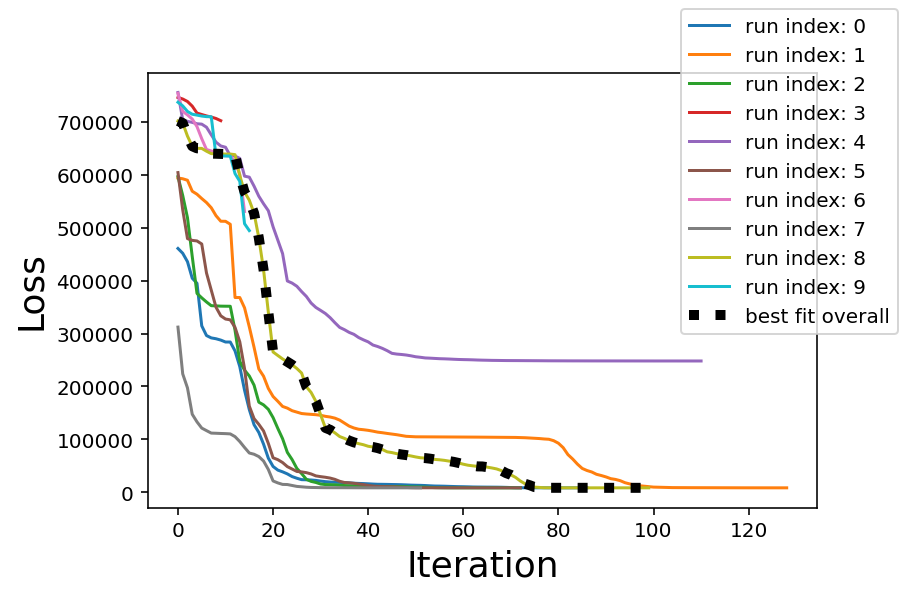

In [11]:
fig, ax = plt.subplots(1, 1)
for n in range(min(10, len(extra_fields['loss_history_list']))):
    ax.plot(extra_fields['loss_history_list'][n], label=f"run index: {n}")
ax.plot(extra_fields['loss_history'], color='k', linewidth=5, linestyle=':', label="best fit overall")
ax.set_ylabel("Loss", fontsize=18)
ax.set_xlabel("Iteration", fontsize=18)
fig.legend()
plt.show()

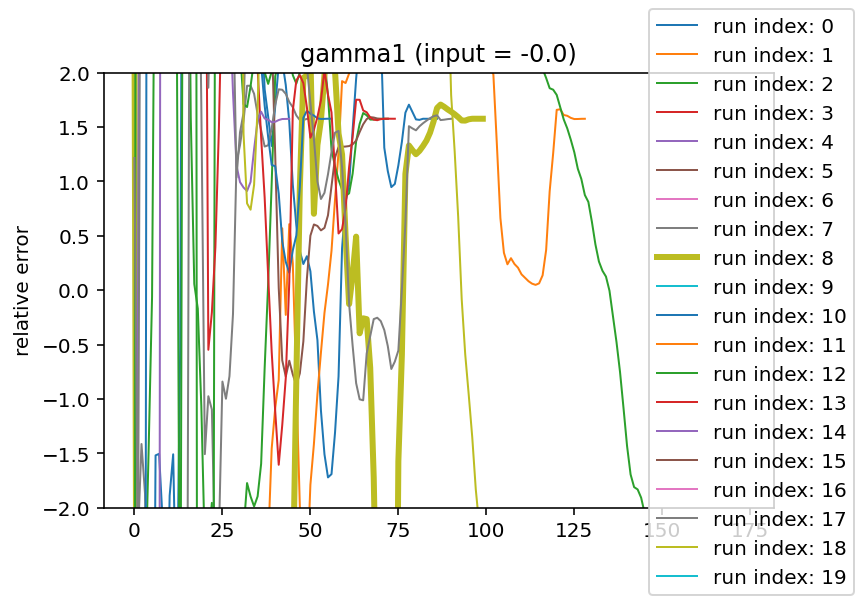

In [12]:
idx_param = 3

fig, ax = plt.subplots(1, 1)
ax.set_title(f"{parameters_ana.names[idx_param]} (input = {input_values[idx_param]:.1f})")
for n in range(min(20, len(extra_fields['param_history_list']))):
    param_track = []
    for i in range(len(extra_fields['param_history_list'][n])):
        param_track.append(extra_fields['param_history_list'][n][i][idx_param])
    param_track = np.array(param_track)
    input_value = input_values[idx_param]
    delta_param = (param_track - input_value) / input_value
    linewidth = 3 if n == extra_fields['best_fit_index'] else 1
    ax.plot(delta_param, label=f"run index: {n}", linewidth=linewidth)
vmax = 2
ax.set_ylim(-vmax, vmax)
ax.set_ylabel("relative error")
fig.legend()
plt.show()

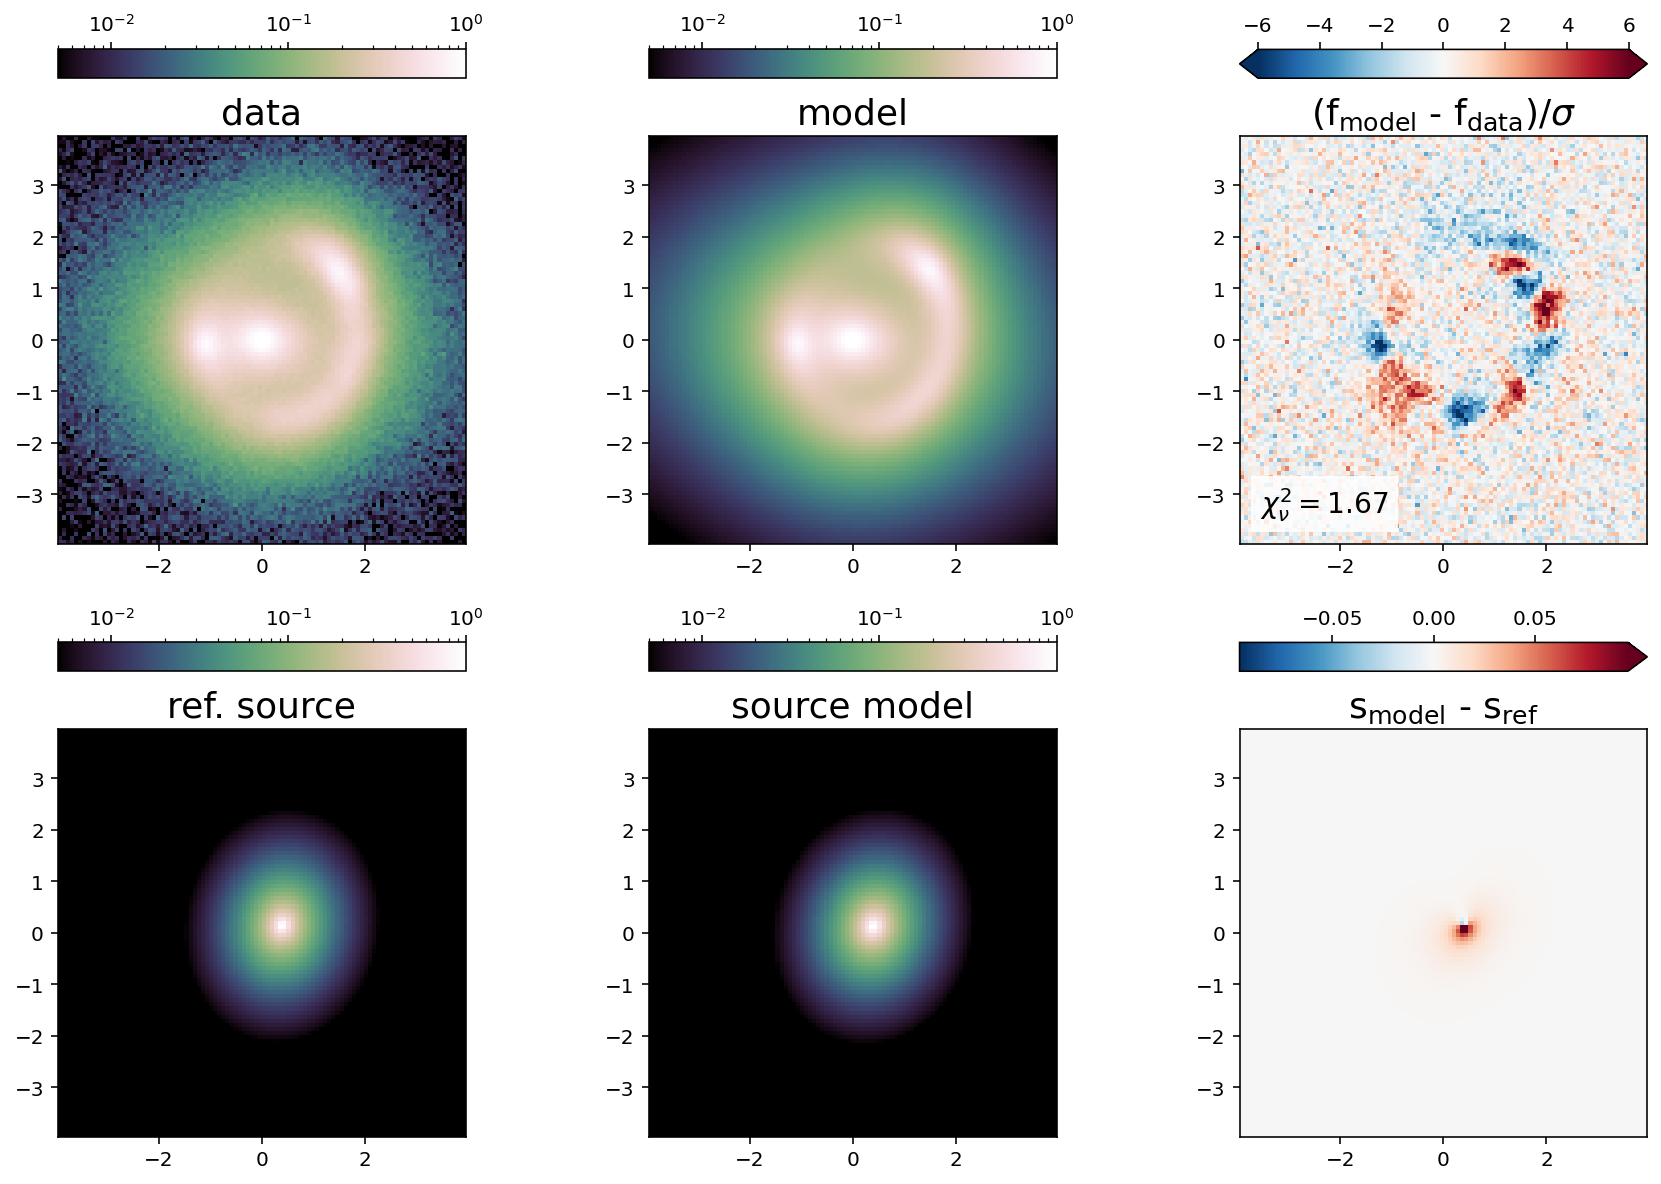

In [13]:
plotter.set_data(data)
plotter.set_ref_source(source_input)
fig = plotter.model_summary(lens_image_ana, kwargs_smooth_fit0, show_source=True)

### Get covariance estimates

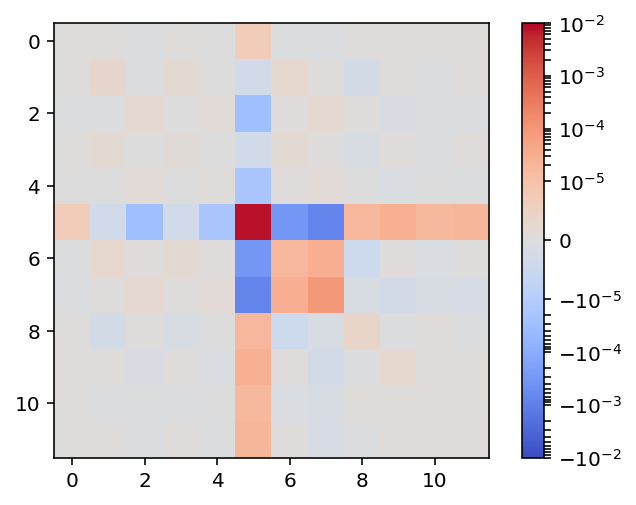

In [14]:
values_bestfit_lenssrc = parameters_ana.best_fit_values()
model_covar = FisherCovariance(parameters_ana, loss_smooth_fit0)

# Fisher information matrices
model_covar.compute_fisher_information(values_bestfit_lenssrc)  # can take time
full_fisher_matrix = model_covar.fisher_matrix
cov_matrix_lenssrc = model_covar.covariance_matrix

plt.imshow(cov_matrix_lenssrc, origin='upper', cmap='coolwarm', 
           norm=SymLogNorm(linthresh=1e-5, linscale=1, vmin=-1e-2, vmax=1e-2))
plt.colorbar()
plt.show()

### Save results

In [15]:
base_filename = f'-real-{perturbation_type}-smooth_potential-smooth_source'

if SAVE_MODELS_FITS:
    
    with open(os.path.join('results', 'sumplot'+base_filename+'.pkl'), 'wb') as f:
        pkl_protocol = 2
        pkl_content = [
            # data
            data,
            
            # model
            lens_image_ana, 
            
            # parameter values
            kwargs_smooth_fit0, 
            None,
            
            # pixelated potential
            None,
            None,
            None,
            None,
            
            # error estimations
            full_fisher_matrix,
            None,
            cov_matrix_lenssrc,
            
            # parameter vectors for corner plot
            None,  # saved in full fit notebook
            values_bestfit_lenssrc,
            None,  # saved in full fit notebook
        ]
        pkl.dump(pkl_content, f, pkl_protocol)

### MCMC sampling

100%|██████████| 150/150 [03:43<00:00,  1.49s/it]


Runtime: 225.23927879333496
Samples shape: (12000, 12)


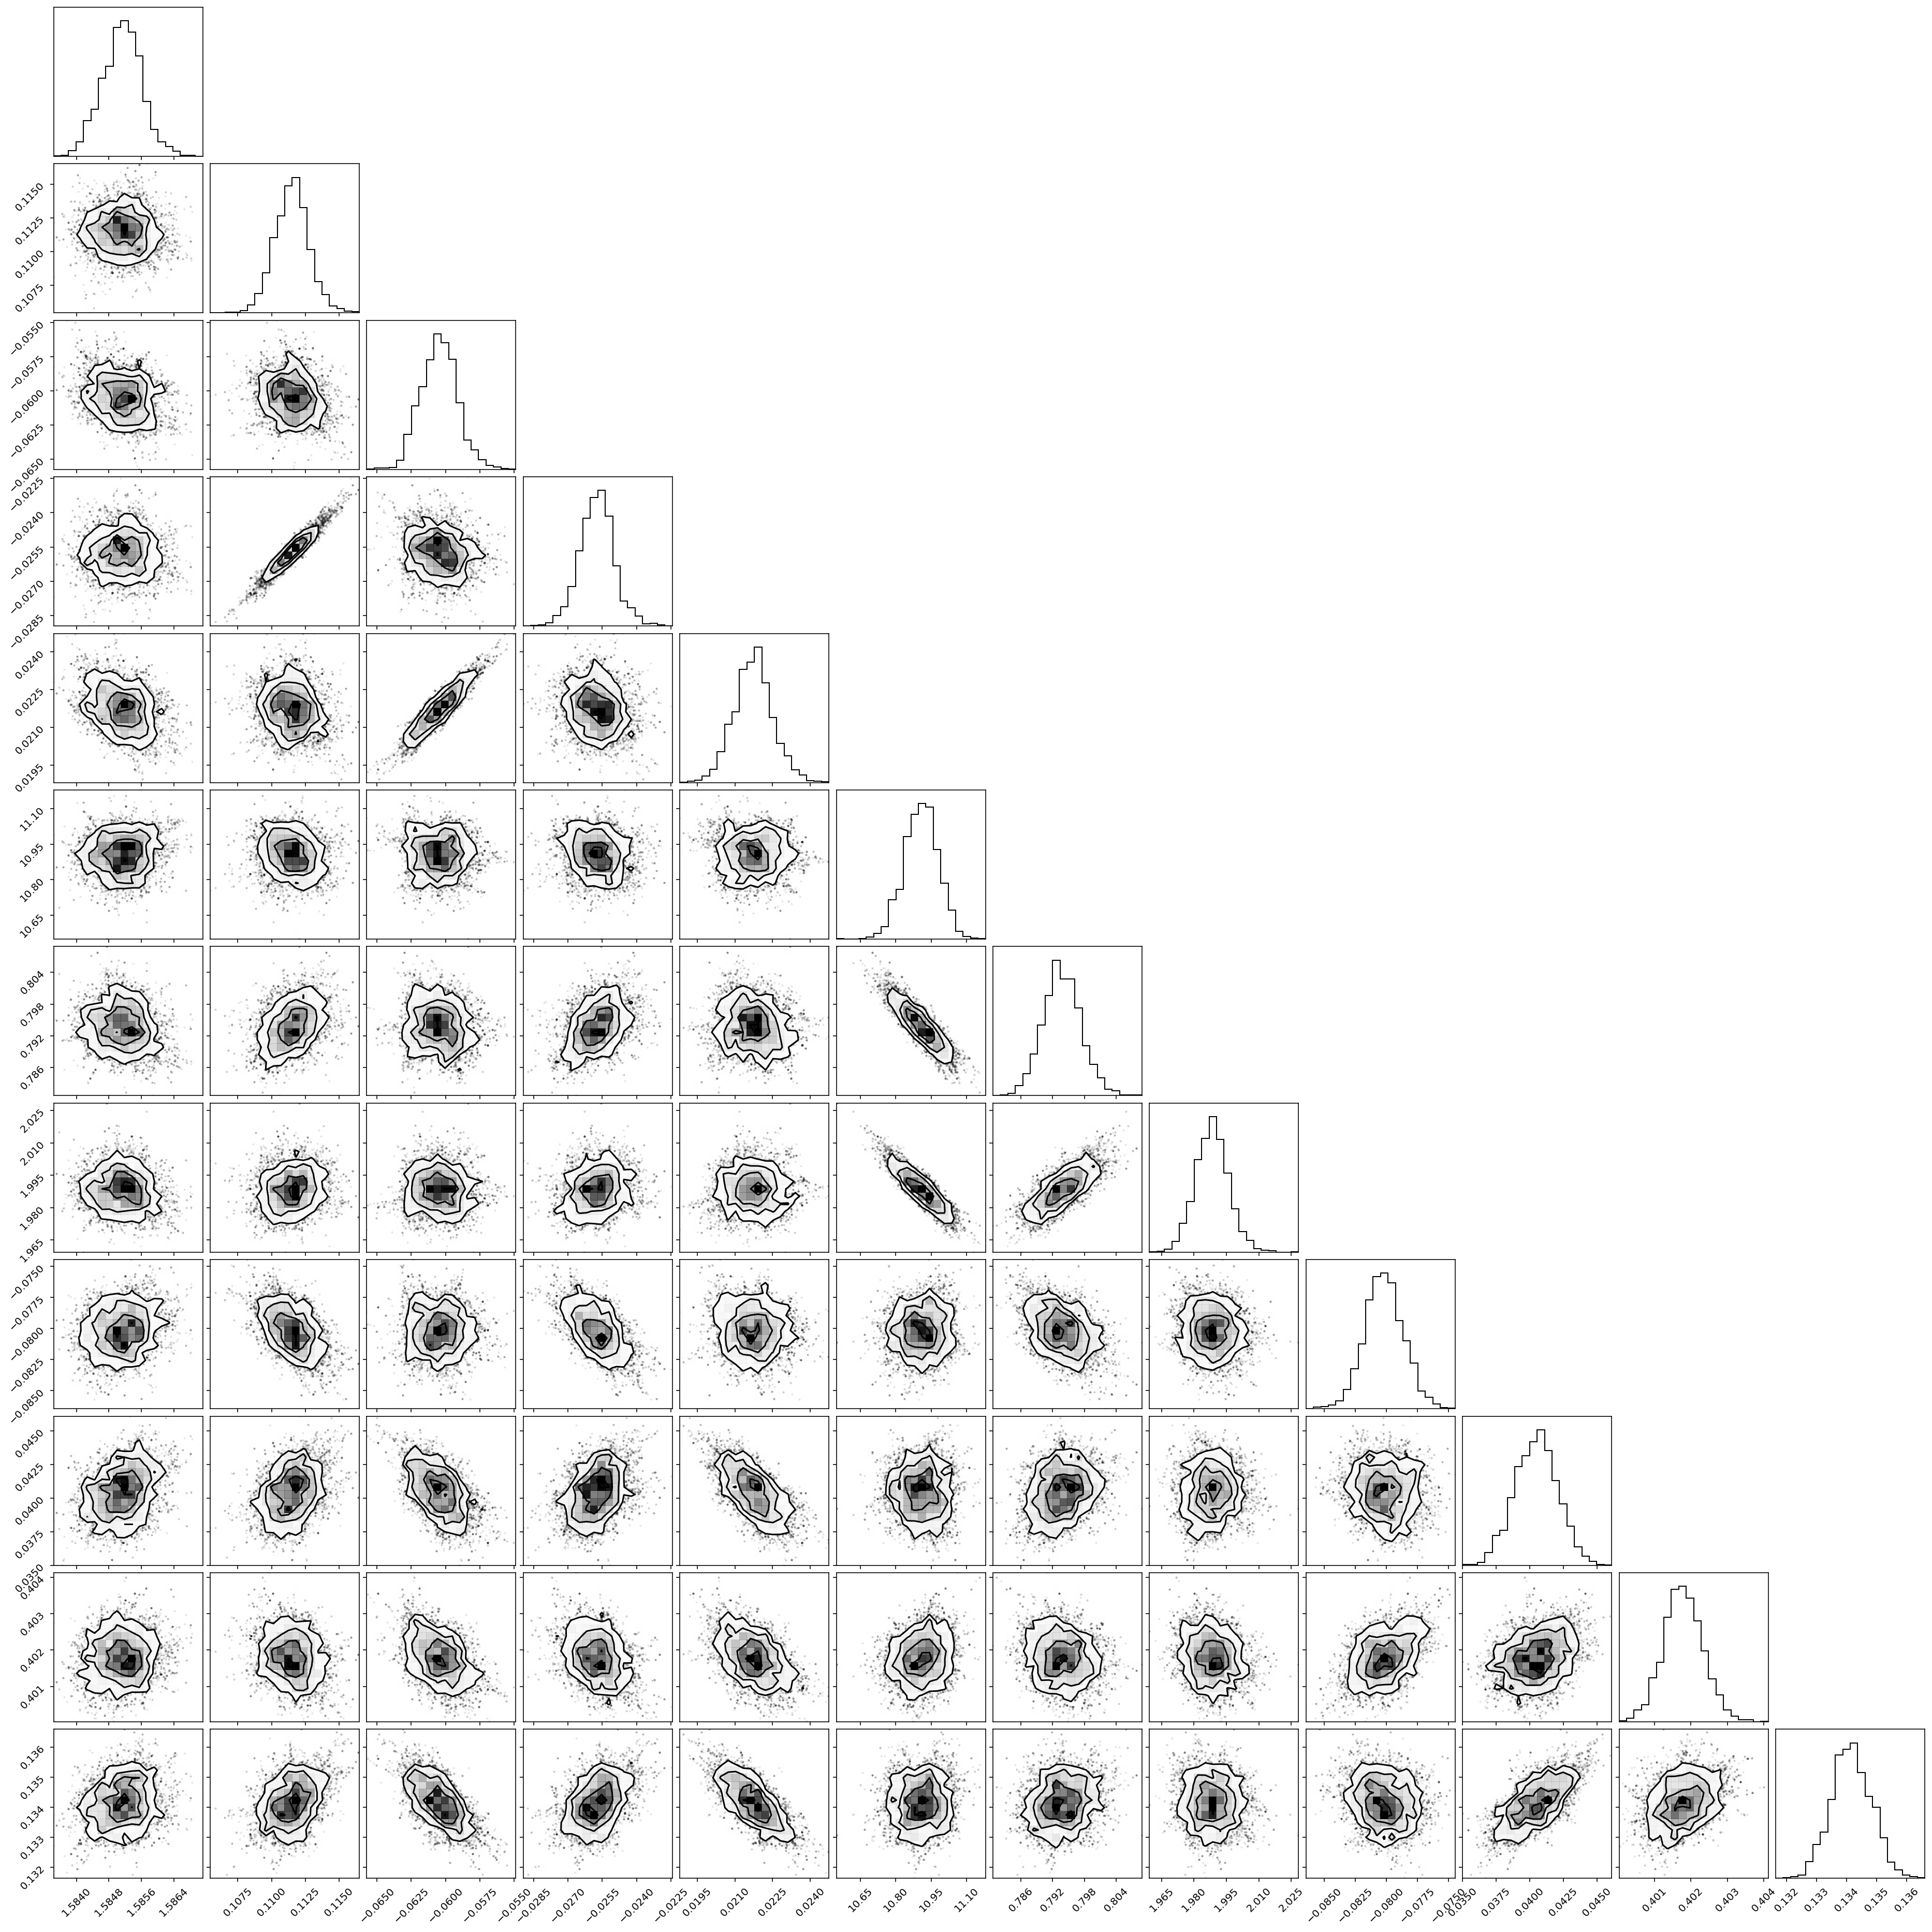

In [16]:
if SAVE_MCMC:
    
    # decide on some scatter to initialize emcee walkers
    # we estimate it based on Fisher matrix
    #kwargs_std = model_covar.get_kwargs_sigma()
    #init_stds  = parameters.kwargs2args(kwargs_std)
    init_stds = np.sqrt(np.abs(np.diag(cov_matrix_lenssrc)))
    
    # here we need to define a non-jitted log-likelihood function
    def log_likelihood_nojit(args):
        # Compute reconstruction with these parameters
        rec = np.array(lens_image_ana.model(**parameters_ana.args2kwargs(args)))
        noise_sigma2 = np.array(lens_image_ana.Noise.C_D_model(rec))
        # log-likelihood
        log_l = - 0.5 * np.sum((data - rec)**2 / noise_sigma2)
        # log-prior
        #log_l += parameters.log_prior_nojit(args)
        return log_l
    
    sampler_mcmc = Sampler(loss_smooth_fit0, parameters_ana)

    samples_mcmc, logL_mcmc, extra_fields_mcmc, runtime \
        = sampler_mcmc.mcmc_emcee(log_likelihood_nojit, init_stds, 
                                  walker_ratio=10, num_warmup=50, num_samples=100, 
                                  restart_from_init=False, num_threads=1)
    print(f"Runtime: {runtime}")
    print(f"Samples shape: {samples_mcmc.shape}")
    
    
    fig = corner.corner(samples_mcmc) #, truths=values_input_lenssrc)
    plt.show()
    
    
    kwargs_smooth_mcmc = deepcopy(parameters_ana.best_fit_values(as_kwargs=True))
    
    mean_values_mcmc_lenssrc = np.mean(samples_mcmc, axis=0)
    diag_cov_matrix_mcmc = np.cov(samples_mcmc.T)
    
    base_filename_mcmc = base_filename + '-MCMC'
    
    with open(os.path.join('results', 'sumplot'+base_filename_mcmc+'.pkl'), 'wb') as f:
        pkl_protocol = 2
        pkl_content = [
            # data
            data,
            
            # model
            lens_image_ana, 
            
            # parameter values
            kwargs_smooth_mcmc, 
            None,
            
            # pixelated potential
            None,
            None,
            None,
            None,
            
            # error estimations
            None,
            None,
            diag_cov_matrix_mcmc,
            
            # parameter vectors for corner plot
            None, #values_input_lenssrc,
            mean_values_mcmc_lenssrc,
            None,
        ]
        pkl.dump(pkl_content, f, pkl_protocol)

(12, 12)


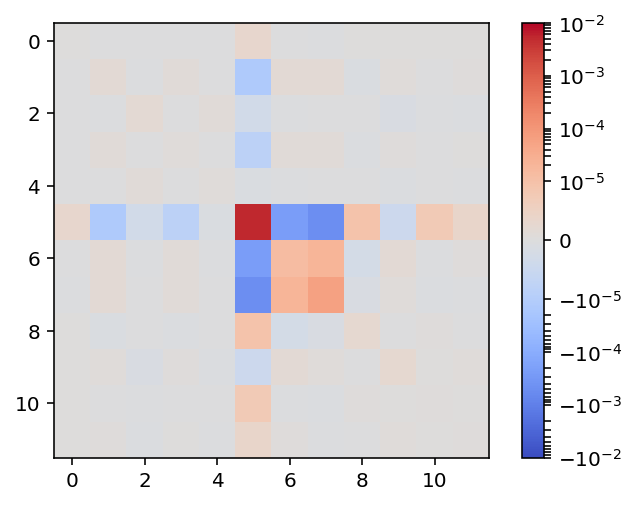

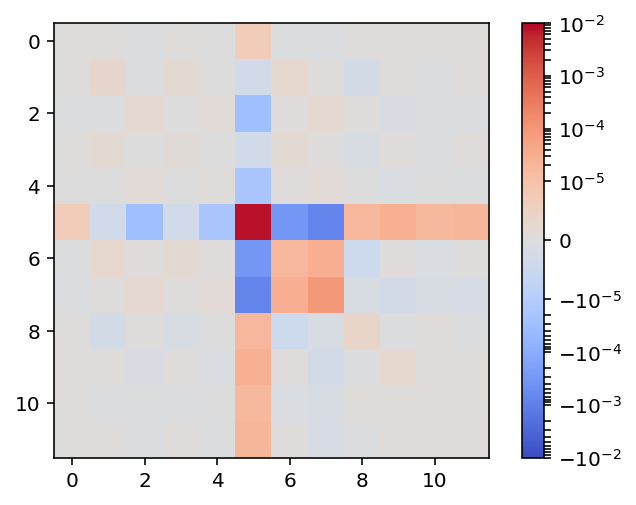

In [23]:
if SAVE_MCMC:
    
    diag_cov_matrix_mcmc_new = np.cov(samples_mcmc.T)
    print(diag_cov_matrix_mcmc_new.shape)
    
    plt.figure()
    plt.imshow(diag_cov_matrix_mcmc_new, origin='upper', cmap='coolwarm', 
               norm=SymLogNorm(linthresh=1e-5, linscale=1, vmin=-1e-2, vmax=1e-2))
    plt.colorbar()
    plt.show()
    
    plt.figure()
    plt.imshow(cov_matrix_lenssrc, origin='upper', cmap='coolwarm', 
               norm=SymLogNorm(linthresh=1e-5, linscale=1, vmin=-1e-2, vmax=1e-2))
    plt.colorbar()
    plt.show()

In [17]:
if stop_after_smooth_fit:
    raise

RuntimeError: No active exception to reraise

## Add more flexbility to the source with wavelets

In [ ]:
# Generate an initial guess for the source
grid_x_src_fit, grid_y_src_fit = lens_image_fit.Grid.model_pixel_coordinates('source')

source_pixels_sersic = lens_image_ana.SourceModel.surface_brightness(grid_x_src_fit, grid_y_src_fit, 
                                                                     kwargs_smooth_fit0['kwargs_source'])
source_pixels_sersic *= lens_image_fit.Grid.pixel_area
kwargs_source_sersic_fit0 = [{'pixels': source_pixels_sersic}]

print(source_pixels_sersic.shape)


# Or use a fully blank image as a starting point 
source_pixels_null = 1e-8 * jnp.ones_like(grid_x_src_fit)
kwargs_source_null = [{'pixels': source_pixels_null}]


plt.imshow(source_pixels_sersic, origin='lower')
plt.colorbar()
plt.show()

In [ ]:
kwargs_init = {
    'kwargs_lens': deepcopy(kwargs_smooth_fit0['kwargs_lens']),
    'kwargs_source': deepcopy(kwargs_source_sersic_fit0),
    #'kwargs_source': deepcopy(kwargs_source_null),
    'kwargs_lens_light': [{}],
}
kwargs_fixed = {
    #'kwargs_lens': kwargs_lens_input,
    'kwargs_lens': [{}, {'ra_0': 0., 'dec_0': 0.}],
    'kwargs_source': [{}],
    'kwargs_lens_light': kwargs_lens_light_input,
}
kwargs_joint = {
    # fix lens center to lens light center
    'lens_with_lens_light': [[(0, 0), ['center_x', 'center_y']]],
}
parameters = Parameters(lens_image_fit, kwargs_init, kwargs_fixed, 
                        kwargs_joint=kwargs_joint, kwargs_prior=None)
print("Number of fitted parameters:", parameters.num_parameters)

In [ ]:
# Create loss
loss_smooth_fit1 = Loss(data, lens_image_fit, parameters, 
                  likelihood_type='l2_norm', 
                  regularization_terms=['l1_starlet_source', 
                                        'l1_battle_source', 
                                        'positivity_source'], 
                  regularization_strengths=[(5, 3), 5, 3])

print("Initial loss:", loss_smooth_fit1(parameters.kwargs2args(kwargs_init)))
print("Number of data points in likelihood:", loss_smooth_fit1.likelihood_num_data_points)

# Optimizer
optimizer_smooth_fit1 = Optimizer(loss_smooth_fit1, parameters)

best_fit, logL, extra_fields, runtime \
    = optimizer_smooth_fit1.optax(max_iterations=500, 
                                 init_learning_rate=1e-3,
                                 restart_from_init=True)
print(f"Runtime: {runtime}")
print("Loss at best-fit:", loss_smooth_fit1(best_fit))
kwargs_smooth_fit1 = deepcopy(parameters.best_fit_values(as_kwargs=True))

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.plot(range(len(extra_fields['loss_history'])), extra_fields['loss_history'])
ax.set_ylabel("Loss", fontsize=18)
ax.set_xlabel("Iteration", fontsize=18)
plt.show()

In [ ]:
fig = plotter.model_summary(lens_image_fit, kwargs_smooth_fit1, show_source=True)

#### Save results

In [ ]:
if SAVE_MODELS_FITS:
    base_filename = f'-real-{perturbation_type}-smooth_potential-wavelet_source'
    
    with open(os.path.join('results', 'sumplot'+base_filename+'.pkl'), 'wb') as f:
        pkl_protocol = 2
        pkl_content = [
            # data
            data,
            
            # model
            lens_image_fit, 
            
            # parameter values
            kwargs_smooth_fit1, 
            None,
            
            # pixelated potential
            None,
            None,
            None,
            None,
            
            # error estimations
            None,
            None,
            None,
            
            # parameter vectors for corner plot
            None,
            None,
            None,
        ]
        pkl.dump(pkl_content, f, pkl_protocol)